## Predicting Water Quality using Machine Learning Models

#### Mounting Drive if working in colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Imporing Required Libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sn
import missingno as msno
import tensorflow as tf
import matplotlib.pyplot as plt #plotting graphs
from fancyimpute import SoftImpute #imputation model
from sklearn.impute import KNNImputer #imputation model
from fancyimpute import IterativeImputer #imputation model

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler #scaling
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error

from sklearn.svm import SVC 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import SelectKBest, f_classif

from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint

In [ ]:
# Define the path to the CSV file
path = 'Water_Quality.csv'
df = pd.read_csv(path)
print(df.head())

           X          Y  Station   Latitude  Longitude   Type  OBJECTID  \
0 -82.063712  26.698713      120  26.698713 -82.063712   Salt         1   
1 -82.063712  26.698713      120  26.698713 -82.063712   Salt         2   
2 -82.063712  26.698713      120  26.698713 -82.063712   Salt         3   
3 -82.034712  26.694521      129  26.694521 -82.034712  Fresh         4   
4 -82.034712  26.694521      129  26.694521 -82.034712  Fresh         5   

      ActivID       DATE  STANO  ...  CHLA TURBID_L  REDOX  ORTH_PO4  \
0  1001091201  10/1/2009    120  ...   6.0      1.2    NaN       NaN   
1  1001091202  10/1/2009    120  ...   NaN      0.8    NaN       NaN   
2  1001091203  10/1/2009    120  ...   NaN      2.7    NaN       NaN   
3  1001091291  10/1/2009    129  ...   2.6      0.8    NaN       NaN   
4  1001091292  10/1/2009    129  ...   NaN      NaN    NaN       NaN   

   ORG_PHOS  NOX_NITR  ORG_NITR  VOSUSOL  VODISOL               TIMEAWARE  
0       NaN      0.05       NaN      NaN

C:\Users\user\AppData\Local\Temp\ipykernel_27552\3585105340.py:3: DtypeWarning: Columns (30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path)


Dataset details

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18148 entries, 0 to 18147
Data columns (total 48 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X          18148 non-null  float64
 1   Y          18148 non-null  float64
 2   Station    18148 non-null  int64  
 3   Latitude   18148 non-null  float64
 4   Longitude  18148 non-null  float64
 5   Type       18148 non-null  object 
 6   OBJECTID   18148 non-null  int64  
 7   ActivID    18148 non-null  int64  
 8   DATE       18148 non-null  object 
 9   STANO      18148 non-null  int64  
 10  D_CODE     18144 non-null  float64
 11  TIME       17899 non-null  object 
 12  TEMPER     17919 non-null  float64
 13  CONDUCT    17763 non-null  float64
 14  DISSO2     17849 non-null  float64
 15  PH         17581 non-null  float64
 16  SAMDEPTH   17855 non-null  float64
 17  SALINITY   17845 non-null  float64
 18  TURBID_F   474 non-null    float64
 19  SECCHI     6213 non-null   float64
 20  CURREN

### Removing redundant features and consider only the key that impact on water quality

In [ ]:
df1 = df.drop(['X', 'Y', 'Station', 'Latitude', 'Longitude','Type','OBJECTID', 
               'ActivID', 'DATE', 'STANO', 'D_CODE', 'TIME', 'SAMDEPTH', 'TURBID_F', 
               'SECCHI', 'CURRENT_', 'YEAR', 'MTH', 'DAY', 'DO_Perc', 'TOSUSOL', 
               'TODISOL', 'CL', 'FECSTREP','CHLA', 'TURBID_L', 'REDOX', 'ORTH_PO4', 
               'NOX_NITR', 'VOSUSOL', 'VODISOL', 'TIMEAWARE', 'ORG_NITR', 'ORG_PHOS'  ], axis=1)
print(df1.head())

   TEMPER  CONDUCT  DISSO2    PH  SALINITY  NH3_NITR  TOT_KJN  NO2_NITR  \
0   28.12   12.200    5.76  7.73       6.9      0.05      0.5     0.025   
1   27.97   12.250    5.79  7.72       6.9      0.05      0.5     0.025   
2   29.95   23.530    0.60  7.07      14.1      0.05      1.0     0.025   
3   28.87    0.673    5.38  7.67       0.3      0.05      0.3     0.025   
4   28.87    0.673    5.52  7.67       0.3       NaN      NaN       NaN   

   NO3_NITR  TOT_NITR TOT_PHOS  BIOLOXD  ALKALIN  FECCOLI  
0     0.025       0.5    0.025      1.2     45.0      6.0  
1     0.025       0.5    0.025      1.2     46.0      NaN  
2     0.025       1.0     0.05      3.6     48.0      NaN  
3     0.025       0.3    0.025      2.7     54.0     16.0  
4       NaN       NaN      NaN      NaN      NaN      NaN  


Checking for null values

In [ ]:
print(df1.isnull().sum())

TEMPER        229
CONDUCT       385
DISSO2        299
PH            567
SALINITY      303
NH3_NITR     4890
TOT_KJN      4939
NO2_NITR     5353
NO3_NITR     5403
TOT_NITR     5280
TOT_PHOS     5041
BIOLOXD      5554
ALKALIN      6284
FECCOLI     12073
dtype: int64


In [ ]:
df1['TOT_PHOS'] = df1['TOT_PHOS'].str.replace('.', '', 1).str.replace(',', '.', 1)
df1['TOT_PHOS'] = df1['TOT_PHOS'].astype(float)

C:\Users\user\AppData\Local\Temp\ipykernel_27552\921250564.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df1['TOT_PHOS'] = df1['TOT_PHOS'].str.replace('.', '', 1).str.replace(',', '.', 1)


### Understanding if missing data shows any pattern

<AxesSubplot:>

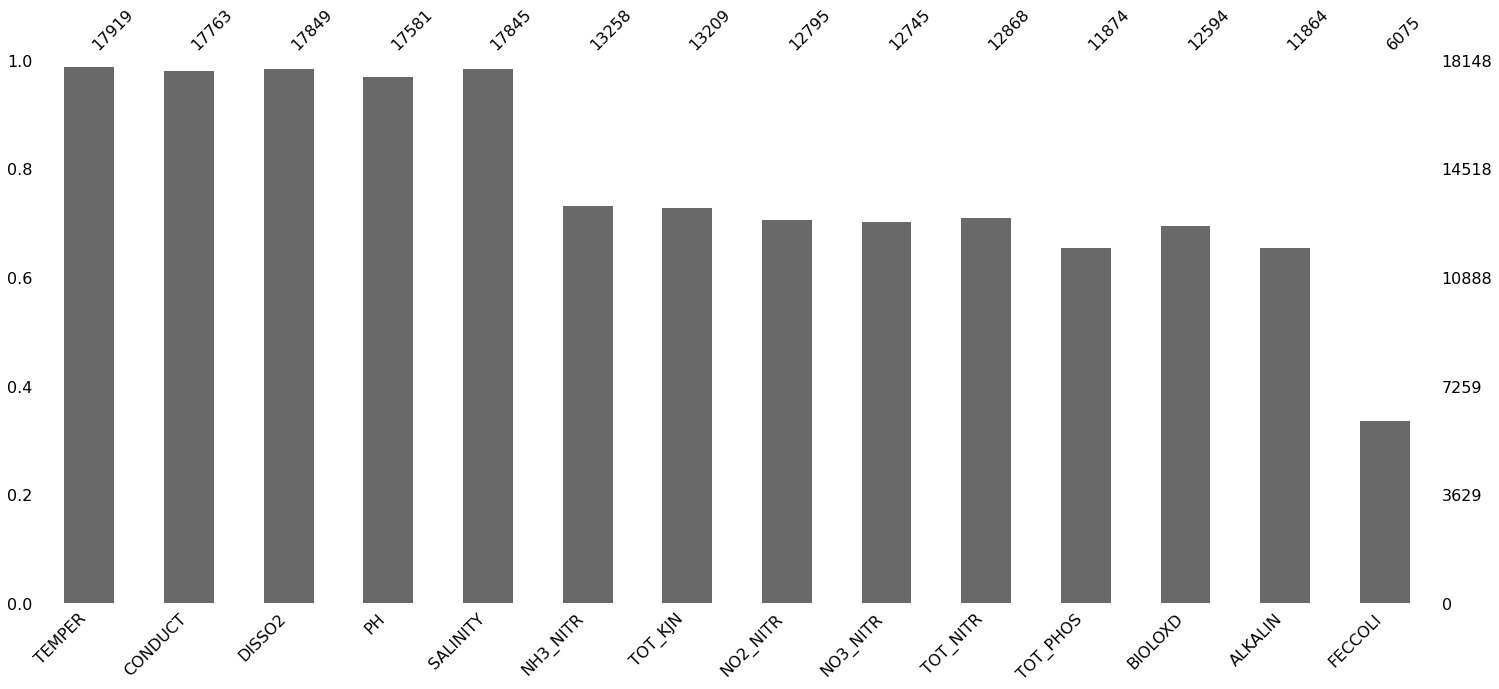

In [ ]:
msno.bar(df1)

<AxesSubplot:>

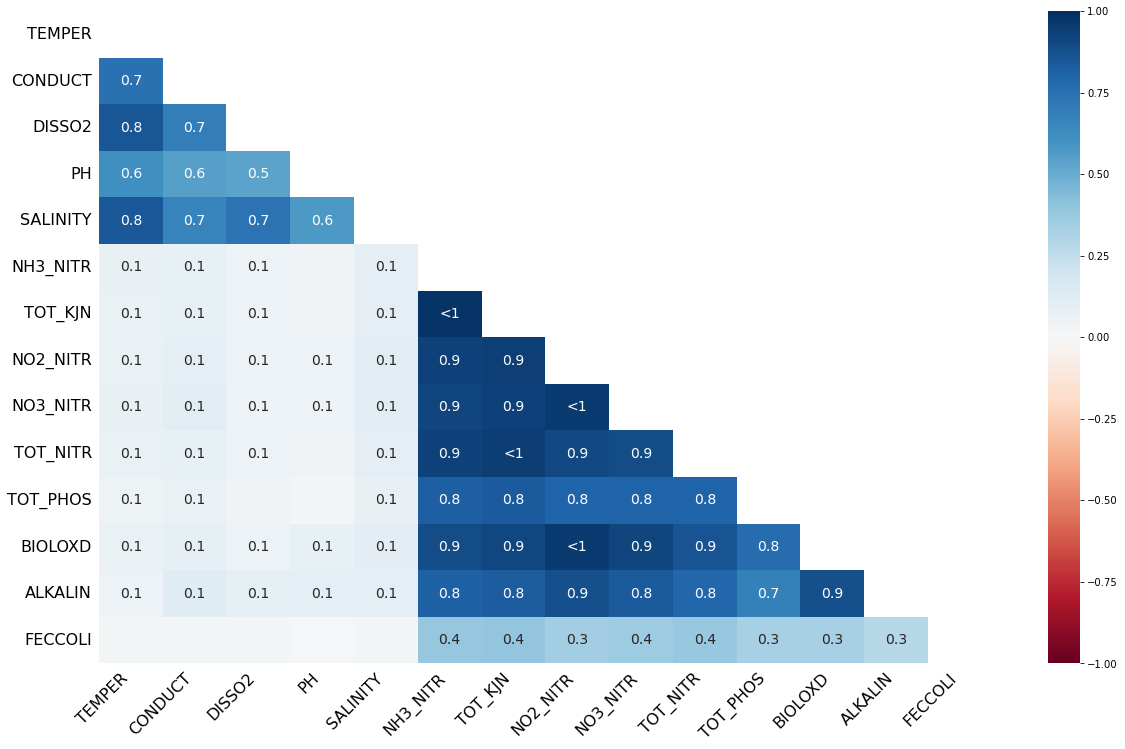

In [ ]:
# in the heatmap values closer to 1 indicate 
# correlation between missing values of one
# column and the missing values of the other column
msno.heatmap(df1)

<AxesSubplot:>

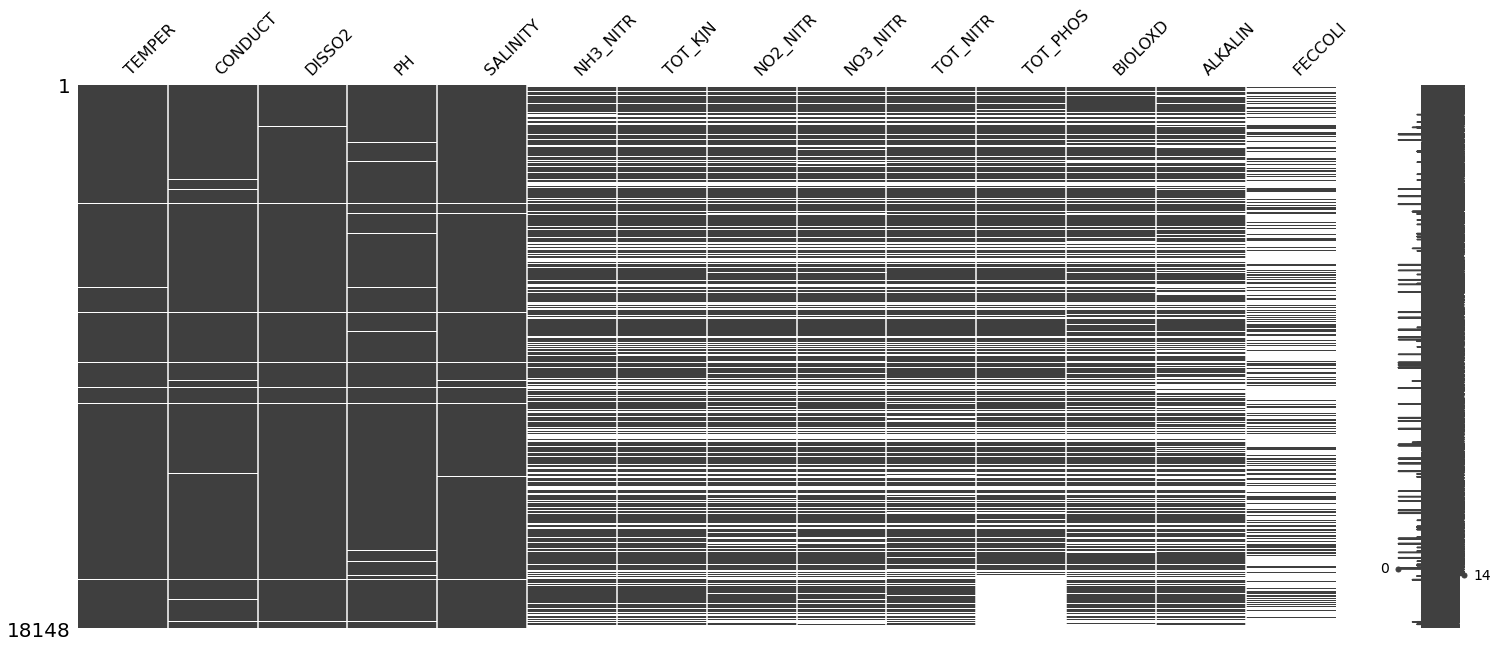

In [ ]:
# Plot the patterns of missing data
msno.matrix(df1)

### The results indicate that null values are considerable in many of the attributes
To impute these number of null vlaues we tried three algorithms: Denoising Autoencoder, SoftImpute, KNN Impute 

### Imputing with Denoising Autoencoder
To do imputation, the trained autoencoder is used to recover the missing data by running it through the encoder and decoder. Before the data is sent to the encoder, any missing numbers are filled in with 0 or random noise or mean (in our case). The missing values in the original data are then filled in with the values from the decoder data.

In [ ]:
# Using a new dataset variable for DAE imputing
# Prepare data: delete unused columns
df3 = df.drop(['X', 'Y', 'Station', 'Latitude', 'Longitude','Type','OBJECTID', 'ActivID', 
               'DATE', 'STANO', 'D_CODE', 'TIME', 'SAMDEPTH', 'TURBID_F', 'SECCHI', 'CURRENT_', 
               'YEAR', 'MTH', 'DAY', 'DO_Perc', 'TOSUSOL', 'TODISOL', 'CL', 'FECSTREP','CHLA', 
               'TURBID_L', 'REDOX', 'ORTH_PO4', 'NOX_NITR', 'VOSUSOL', 'VODISOL', 'TIMEAWARE', 
               'ORG_NITR', 'ORG_PHOS'  ], axis=1)
print(df3.isnull().sum())

TEMPER        229
CONDUCT       385
DISSO2        299
PH            567
SALINITY      303
NH3_NITR     4890
TOT_KJN      4939
NO2_NITR     5353
NO3_NITR     5403
TOT_NITR     5280
TOT_PHOS     5041
BIOLOXD      5554
ALKALIN      6284
FECCOLI     12073
dtype: int64


In [ ]:
# Convert attribute type in float
df3['TOT_PHOS'] = df3['TOT_PHOS'].str.replace('.', '', 1).str.replace(',', '.', 1)
df3['TOT_PHOS'] = df3['TOT_PHOS'].astype(float)

C:\Users\user\AppData\Local\Temp\ipykernel_27552\769646148.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df3['TOT_PHOS'] = df3['TOT_PHOS'].str.replace('.', '', 1).str.replace(',', '.', 1)


In [ ]:
# Normalize the data
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(df3)

# Mask the missing values
missing_mask = np.isnan(data_normalized)

# Replace NaN values with the mean of the observed values
data_imputed = np.copy(data_normalized)
data_imputed[missing_mask] = np.nanmean(data_normalized)

# Split the dataset into training and testing sets
X_train, X_test = train_test_split(data_imputed, test_size=0.2, random_state=42)

# Define the Denoising Autoencoder model
input_dim = data_imputed.shape[1]
encoding_dim = 64

input_data = tf.keras.Input(shape=(input_dim,))
encoded = tf.keras.layers.Dense(encoding_dim, activation='relu')(input_data)
decoded = tf.keras.layers.Dense(input_dim, activation='linear')(encoded)

autoencoder = tf.keras.Model(input_data, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
epochs = 100
batch_size = 16

autoencoder.fit(
    X_train, X_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(X_test, X_test)
)

# Impute the missing values using the autoencoder
data_imputed_dae = autoencoder.predict(data_imputed)

# Replace the imputed values in the original dataset
data_normalized[missing_mask] = data_imputed_dae[missing_mask]

# Convert the imputed data back to the original scale
imputed_data = scaler.inverse_transform(data_normalized)

# Convert the imputed data back to a DataFrame
imputed_data = pd.DataFrame(imputed_data, columns=df3.columns)

#print(imputed_data)


Epoch 1/100
908/908 [==============================] - 2s 2ms/step - loss: 0.0075 - val_loss: 2.3746e-04
Epoch 2/100
908/908 [==============================] - 2s 2ms/step - loss: 1.0127e-04 - val_loss: 2.9334e-05
Epoch 3/100
908/908 [==============================] - 2s 2ms/step - loss: 2.3903e-05 - val_loss: 1.8639e-05
Epoch 4/100
908/908 [==============================] - 2s 2ms/step - loss: 1.0552e-05 - val_loss: 7.3948e-06
Epoch 5/100
908/908 [==============================] - 2s 2ms/step - loss: 4.8277e-06 - val_loss: 2.1665e-06
Epoch 6/100
908/908 [==============================] - 2s 2ms/step - loss: 2.0597e-06 - val_loss: 2.2303e-06
Epoch 7/100
908/908 [==============================] - 2s 2ms/step - loss: 1.4515e-06 - val_loss: 5.7333e-07
Epoch 8/100
908/908 [==============================] - 2s 2ms/step - loss: 1.3419e-06 - val_loss: 6.6698e-07
Epoch 9/100
908/908 [==============================] - 2s 2ms/step - loss: 1.1544e-06 - val_loss: 5.2734e-07
Epoch 10/100
908/908 [=

908/908 [==============================] - 2s 2ms/step - loss: 9.0457e-07 - val_loss: 3.6502e-07
Epoch 76/100
908/908 [==============================] - 2s 2ms/step - loss: 8.6153e-07 - val_loss: 4.3450e-07
Epoch 77/100
908/908 [==============================] - 2s 2ms/step - loss: 5.7076e-07 - val_loss: 2.2530e-07
Epoch 78/100
908/908 [==============================] - 2s 2ms/step - loss: 7.5930e-07 - val_loss: 1.1636e-06
Epoch 79/100
908/908 [==============================] - 2s 2ms/step - loss: 6.1599e-07 - val_loss: 4.3465e-07
Epoch 80/100
908/908 [==============================] - 2s 2ms/step - loss: 7.7302e-07 - val_loss: 5.3660e-07
Epoch 81/100
908/908 [==============================] - 2s 2ms/step - loss: 8.2719e-07 - val_loss: 3.7450e-07
Epoch 82/100
908/908 [==============================] - 2s 2ms/step - loss: 5.7787e-07 - val_loss: 2.1662e-07
Epoch 83/100
908/908 [==============================] - 2s 2ms/step - loss: 8.1975e-07 - val_loss: 4.8830e-07
Epoch 84/100
908/908 [=

In [ ]:
print(imputed_data.isnull().sum())

TEMPER      0
CONDUCT     0
DISSO2      0
PH          0
SALINITY    0
NH3_NITR    0
TOT_KJN     0
NO2_NITR    0
NO3_NITR    0
TOT_NITR    0
TOT_PHOS    0
BIOLOXD     0
ALKALIN     0
FECCOLI     0
dtype: int64


In [ ]:
# 1:good 0:poor
imputed_data['water_quality'] = (
    (imputed_data['DISSO2'] < 6) &
    (imputed_data['PH'] >= 6.5) &
    (imputed_data['PH'] <= 8.0) &
    (imputed_data['SALINITY'] < 7) &
    (imputed_data['NH3_NITR'] < 0.2) &
    (imputed_data['TOT_KJN'] < 1) &
    (imputed_data['NO2_NITR'] < 1) &
    (imputed_data['NO3_NITR'] < 10) & 
    (imputed_data['TOT_NITR'] < 10) &
    (imputed_data['TOT_PHOS'] < 10) &
    (imputed_data['BIOLOXD'] < 5) &
    (imputed_data['ALKALIN'] < 200)
).map({True: 'good', False: 'poor'})


In [ ]:
imputed_data['water_quality'].value_counts()

poor    17164
good      984
Name: water_quality, dtype: int64

In [ ]:
#TODO: Validate
# Calculate the mean squared error
# mse = mean_squared_error(data_imputed_dae.flatten(), df3)
# # Take the square root of the mean squared error to get the RMSE
# rmse = np.sqrt(mse)
# print(f"RMSE: {rmse}")

In [ ]:
mse_dae = np.square(df3 - imputed_data).mean().mean()
rmse_dae = np.sqrt(mse_dae)
print(rmse_dae)


2.2302278171723454e-15


### Imputing using SoftImpute

In [ ]:
# copy the dataframe into a new variable
df4 = df3

In [ ]:
# create new dataset containing all values
no_missing_values_df = df4.dropna()


In [ ]:
imputer = SoftImpute()

# Fit the imputer on the dataset and transform the data
imputed_data1 = imputer.fit_transform(df4)

# Convert the imputed data back to a DataFrame
imputed_data1= pd.DataFrame(imputed_data1, columns=df4.columns)

[SoftImpute] Max Singular Value of X_init = 22249.643406
[SoftImpute] Iter 1: observed MAE=1.410542 rank=5
[SoftImpute] Iter 2: observed MAE=1.406095 rank=5
[SoftImpute] Iter 3: observed MAE=1.406250 rank=5
[SoftImpute] Iter 4: observed MAE=1.406805 rank=5
[SoftImpute] Iter 5: observed MAE=1.407348 rank=5
[SoftImpute] Iter 6: observed MAE=1.407826 rank=5
[SoftImpute] Iter 7: observed MAE=1.408227 rank=5
[SoftImpute] Iter 8: observed MAE=1.408555 rank=5
[SoftImpute] Iter 9: observed MAE=1.408818 rank=5
[SoftImpute] Iter 10: observed MAE=1.409030 rank=5
[SoftImpute] Iter 11: observed MAE=1.409201 rank=5
[SoftImpute] Iter 12: observed MAE=1.409342 rank=5
[SoftImpute] Iter 13: observed MAE=1.409457 rank=5
[SoftImpute] Iter 14: observed MAE=1.409553 rank=5
[SoftImpute] Iter 15: observed MAE=1.409633 rank=5
[SoftImpute] Iter 16: observed MAE=1.409701 rank=5
[SoftImpute] Iter 17: observed MAE=1.409761 rank=5
[SoftImpute] Iter 18: observed MAE=1.409814 rank=5
[SoftImpute] Iter 19: observed MAE

In [ ]:
imputed_data1['water_quality'] = (
    (imputed_data1['CONDUCT'] < 50.0) &
    (imputed_data1['DISSO2'] < 6.0) &
    (imputed_data1['PH'] >= 6.5) &
    (imputed_data1['PH'] <= 8.0) &
    (imputed_data1['SALINITY'] < 7) &
    (imputed_data1['NH3_NITR'] < 0.2) &
    (imputed_data1['TOT_KJN'] < 1.0) &
    (imputed_data1['NO2_NITR'] < 1.0) &
    (imputed_data1['NO3_NITR'] < 10.0) & 
    (imputed_data1['TOT_NITR'] < 10.0) &
    (imputed_data1['TOT_PHOS'] < 10.0) &
    (imputed_data1['BIOLOXD'] < 5) &
    (imputed_data1['ALKALIN'] < 200)&
    (imputed_data1['FECCOLI'] < 200)
).map({True: 'good', False: 'poor'})


In [ ]:
imputed_data1['water_quality'].value_counts()

poor    15618
good     2530
Name: water_quality, dtype: int64

In [ ]:
mse_softimpute = np.square(df4 - imputed_data1).mean().mean()
rmse_softimpute = np.sqrt(mse_softimpute)
print(rmse_softimpute)

0.0


### KNN Impute

In [ ]:
df5 = df3

In [ ]:
# Initialize the KNNImputer with the desired number of neighbors
k = 4
imputer = KNNImputer(n_neighbors=k)

# Fit the imputer on the dataset and transform the data
imputed_data2 = imputer.fit_transform(df5)

# Convert the imputed data back to a DataFrame
imputed_data2 = pd.DataFrame(imputed_data2, columns=df5.columns)


print(imputed_data2.isnull().sum())

TEMPER      0
CONDUCT     0
DISSO2      0
PH          0
SALINITY    0
NH3_NITR    0
TOT_KJN     0
NO2_NITR    0
NO3_NITR    0
TOT_NITR    0
TOT_PHOS    0
BIOLOXD     0
ALKALIN     0
FECCOLI     0
dtype: int64


In [ ]:
imputed_data2['water_quality'] = (
    (imputed_data2['CONDUCT'] < 50.0) &
    (imputed_data2['DISSO2'] < 6.0) &
    (imputed_data2['PH'] >= 6.5) &
    (imputed_data2['PH'] <= 8.0) &
    (imputed_data2['SALINITY'] < 7) &
    (imputed_data2['NH3_NITR'] < 0.2) &
    (imputed_data2['TOT_KJN'] < 1.0) &
    (imputed_data2['NO2_NITR'] < 1.0) &
    (imputed_data2['NO3_NITR'] < 10.0) & 
    (imputed_data2['TOT_NITR'] < 10.0) &
    (imputed_data2['TOT_PHOS'] < 10.0) &
    (imputed_data2['BIOLOXD'] < 5) &
    (imputed_data2['ALKALIN'] < 200)&
    (imputed_data2['FECCOLI'] < 200)
).map({True: 'good', False: 'poor'})


In [ ]:
imputed_data2['water_quality'].value_counts()

poor    16810
good     1338
Name: water_quality, dtype: int64

In [ ]:
# mse_knnmpute = np.square(df5 - imputed_data2).mean().mean()
# rmse_knnimpute = np.sqrt(mse_knnmpute)
# print(rmse_knnimpute)
# mean_squared_error(imputed_data2, df5, squared=False)
# rmse_knn = np.sqrt(mean_squared_error(imputed_data2, df5, squared=False))
# print(rmse_knn)

MICE

In [ ]:
df6 = df3

In [ ]:
# Fit the MICE imputer on the dataset and transform the data
imputer_mice = IterativeImputer()
imputed_data_mice = imputer_mice.fit_transform(df6)

# Convert the imputed data back to a DataFrame
imputed_data3 = pd.DataFrame(imputed_data_mice, columns=df6.columns)

# Check for missing values in the imputed dataset
print(imputed_data3.isnull().sum())


TEMPER      0
CONDUCT     0
DISSO2      0
PH          0
SALINITY    0
NH3_NITR    0
TOT_KJN     0
NO2_NITR    0
NO3_NITR    0
TOT_NITR    0
TOT_PHOS    0
BIOLOXD     0
ALKALIN     0
FECCOLI     0
dtype: int64


In [ ]:
imputed_data3['water_quality'] = (
    (imputed_data3['CONDUCT'] < 50.0) &
    (imputed_data3['DISSO2'] < 6.0) &
    (imputed_data3['PH'] >= 6.5) &
    (imputed_data3['PH'] <= 8.0) &
    (imputed_data3['SALINITY'] < 7) &
    (imputed_data3['NH3_NITR'] < 0.2) &
    (imputed_data3['TOT_KJN'] < 1.0) &
    (imputed_data3['NO2_NITR'] < 1.0) &
    (imputed_data3['NO3_NITR'] < 10.0) & 
    (imputed_data3['TOT_NITR'] < 10.0) &
    (imputed_data3['TOT_PHOS'] < 10.0) &
    (imputed_data3['BIOLOXD'] < 5) &
    (imputed_data3['ALKALIN'] < 200)&
    (imputed_data3['FECCOLI'] < 200)
).map({True: 'good', False: 'poor'})


In [ ]:
imputed_data1['water_quality'].value_counts()

poor    15618
good     2530
Name: water_quality, dtype: int64

In [ ]:
mse_mice = np.square(df6 - imputed_data3).mean().mean()
rmse_mice = np.sqrt(mse_mice)
print(rmse_mice)

0.0


we've seen that soft impute gives best outcome, so our final data set would be imputed_data1

Data Visualization

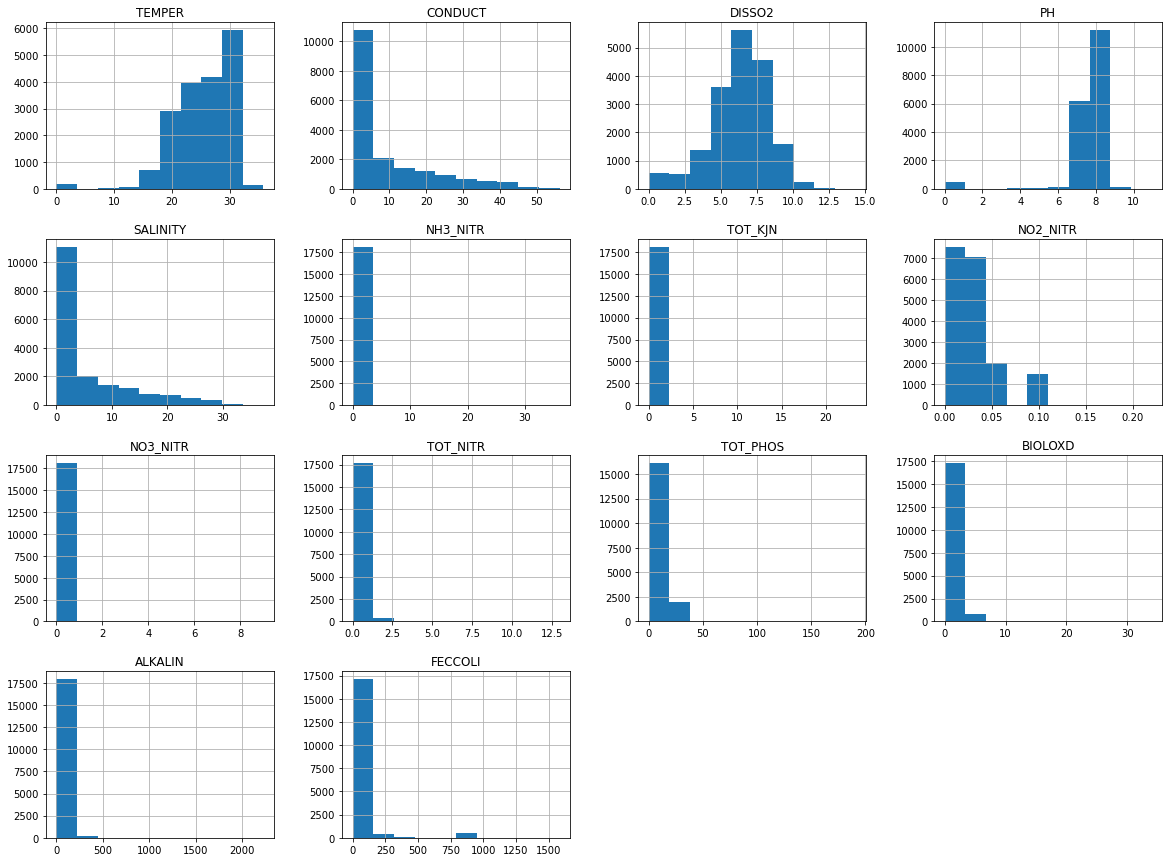

In [ ]:
imputed_data1.hist(bins=10, figsize=(20,15))
plt.show()

Heat map for the features

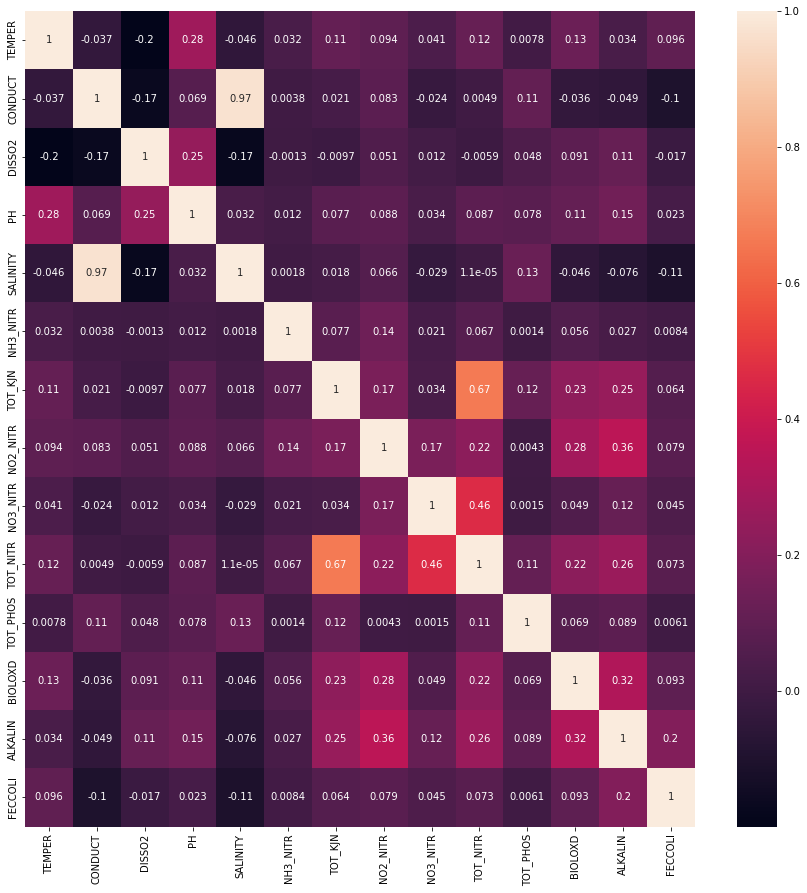

In [ ]:
X = imputed_data1.drop('water_quality', axis=1)
X= X.corr()
plt.figure(figsize=(15,15))
# plotting the heatmap
hm = sn.heatmap(data = X, annot=True)

# displaying the plotted heatmap
plt.show()

In [ ]:
def calculate_outlier_percentage(data, columns):
    outlier_percentages = []
    for col in columns:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
        outlier_percentage = (len(outliers) / len(data)) * 100
        outlier_percentages.append(outlier_percentage)

    return outlier_percentages

cols_to_plot1 = ['TEMPER', 'CONDUCT', 'DISSO2', 'PH', 'SALINITY']
cols_to_plot2 = ['NH3_NITR', 'TOT_KJN', 'NO2_NITR', 'NO3_NITR', 'TOT_NITR']
cols_to_plot3 = ['TOT_PHOS', 'BIOLOXD', 'ALKALIN', 'FECCOLI']

outlier_percentages1 = calculate_outlier_percentage(imputed_data1, cols_to_plot1)
outlier_percentages2 = calculate_outlier_percentage(imputed_data1, cols_to_plot2)
outlier_percentages3 = calculate_outlier_percentage(imputed_data1, cols_to_plot3)

print("Outlier percentages for cols_to_plot1:", outlier_percentages1)
print("Outlier percentages for cols_to_plot2:", outlier_percentages2)
print("Outlier percentages for cols_to_plot3:", outlier_percentages3)


Outlier percentages for cols_to_plot1: [1.0634780692087282, 5.818823010800088, 3.5486003967379323, 4.975754904121666, 6.744544853427375]
Outlier percentages for cols_to_plot2: [34.2792594225259, 5.0253471456909855, 8.193740357064138, 17.86973771214459, 2.6338990522371613]
Outlier percentages for cols_to_plot3: [13.13643376680626, 3.691866872382632, 0.016530747189772977, 9.169054441260744]


We can see all the outliers are less than or equal to 10% and those are reasonable as river bodies in some regions may near to industries which shows the impact, so that's why I haven't deleted those outliers. We are not going to consider them as outliers as they are exceptional cases and we need to include them in our prediction.

For our data set we are facing imbalance in data, for these type of data we need to follow ensemble methods other wise we are gonna face overfitting problem. We 've tried by checking the bagging models to is it really overfitting or not.

**Bootstrap Aggregating**

In [ ]:
# Split the data into features (X) and target (y)
X = imputed_data.drop('water_quality', axis=1)
y = imputed_data['water_quality']
y = [ 1 if i == "good" else 0 for i in y ]

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


create and train the bagging model

In [ ]:
# Create a BaggingClassifier
bagging_model = BaggingClassifier(n_estimators=100, random_state=42)

# Train the model
bagging_model.fit(X_train, y_train)

BaggingClassifier(n_estimators=100, random_state=42)

In [ ]:
# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train the BaggingClassifier on the resampled data
bagging_model = BaggingClassifier(n_estimators=100, random_state=42)
bagging_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = bagging_model.predict(X_test)

# Evaluate the model using different metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9985307621671258
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5127
           1       0.99      0.98      0.99       318

    accuracy                           1.00      5445
   macro avg       0.99      0.99      0.99      5445
weighted avg       1.00      1.00      1.00      5445

[[5124    3]
 [   5  313]]


Now we are trying to change hyperparameters to see any changes are there are not.

In [ ]:
# Define the hyperparameter grid
param_dist = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.5, 0.7, 1.0],
    'max_features': [0.5, 0.7, 1.0],
}

# Instantiate the RandomizedSearchCV object
random_search = RandomizedSearchCV(BaggingClassifier(random_state=42), 
                                   param_distributions=param_dist, n_iter=10, cv=5, 
                                   scoring='f1_macro', random_state=42)

# Fit the random search to the resampled data
random_search.fit(X_train_resampled, y_train_resampled)

# Print the best hyperparameters
print("Best hyperparameters:", random_search.best_params_)

# Train a new BaggingClassifier with the best hyperparameters
best_bagging_model = random_search.best_estimator_
best_bagging_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = best_bagging_model.predict(X_test)

# Evaluate the model using different metrics
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Best hyperparameters: {'n_estimators': 50, 'max_samples': 0.7, 'max_features': 1.0}
Accuracy: 0.9985307621671258
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5127
           1       0.99      0.99      0.99       318

    accuracy                           1.00      5445
   macro avg       0.99      0.99      0.99      5445
weighted avg       1.00      1.00      1.00      5445

[[5123    4]
 [   4  314]]


we've selected most significant features by using f_classif score and distributed weights for two classes and constructed svm model on weak classifier to reduce overfitting and increase model stability. We've build bagging classifier model and do undersampling to balance the class distribution. Then we trained the model

In [ ]:
# 1. Feature selection
k_best = SelectKBest(score_func=f_classif, k=14)
X_selected = k_best.fit_transform(X, y)

# 2. Assign different misclassification costs
class_weights = {0: 1, 1: 10}  

# 3. Construct weak classifiers based on the SVM model
svm = SVC(kernel="linear", class_weight=class_weights, probability=True, random_state=42)

# 4. Bagging with weak classifiers
bagging_svm = BaggingClassifier(base_estimator=svm, n_estimators=10, random_state=42)

# Create a pipeline
pipeline = Pipeline([
    ("bagging_svm", bagging_svm)
])

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.3, random_state=42)

# Apply undersampling
undersampler = RandomUnderSampler(sampling_strategy="majority", random_state=42)
X_train_resampled, y_train_resampled = undersampler.fit_resample(X_train, y_train)

# Fit the pipeline
pipeline.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9057851239669421
              precision    recall  f1-score   support

           0       1.00      0.90      0.95      5127
           1       0.38      0.99      0.55       318

    accuracy                           0.91      5445
   macro avg       0.69      0.95      0.75      5445
weighted avg       0.96      0.91      0.92      5445

[[4616  511]
 [   2  316]]


In [ ]:
X_train = np.array(X_train)
y_train =np.array(y_train)
X_test = np.array(X_test)
y_test =np.array(y_test)

In [ ]:
#y_train_resampled_b = y_train_resampled.apply(lambda x: 0 if x == 'poor' else 1)
#y_test_resampled_b = y_test.apply(lambda x: 0 if x == 'poor' else 1)

 

In [ ]:
#Artificial Neural Network model
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

# Define the model architecture
model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# save model locally
model_path='/model/ann_model.h5'
checkpointer = ModelCheckpoint(model_path, monitor='loss',verbose=1,save_best_only=True,
                               save_weights_only=False, mode='auto',save_freq='epoch')
callback_list=[checkpointer]


save = model.fit(X_train, y_train, batch_size=32, 
                 validation_data=(X_test, y_test), 
                 epochs=20,callbacks=[callback_list])

Epoch 1/20
383/397 [===========================>..] - ETA: 0s - loss: 1.5467 - accuracy: 0.9116
Epoch 1: loss improved from inf to 1.51161, saving model to /model\ann_model.h5
397/397 [==============================] - 3s 5ms/step - loss: 1.5116 - accuracy: 0.9106 - val_loss: 0.2079 - val_accuracy: 0.9416
Epoch 2/20
386/397 [============================>.] - ETA: 0s - loss: 0.2553 - accuracy: 0.9322
Epoch 2: loss improved from 1.51161 to 0.25326, saving model to /model\ann_model.h5
397/397 [==============================] - 2s 5ms/step - loss: 0.2533 - accuracy: 0.9323 - val_loss: 0.1826 - val_accuracy: 0.9416
Epoch 3/20
395/397 [============================>.] - ETA: 0s - loss: 0.1797 - accuracy: 0.9432
Epoch 3: loss improved from 0.25326 to 0.17919, saving model to /model\ann_model.h5
397/397 [==============================] - 2s 4ms/step - loss: 0.1792 - accuracy: 0.9433 - val_loss: 0.1646 - val_accuracy: 0.9416
Epoch 4/20
376/397 [===========================>..] - ETA: 0s - loss: 0

In [ ]:
y_pred = model.predict(X_test)

171/171 [==============================] - 0s 1ms/step


In [ ]:
y_pred=(y_pred > 0.5).astype(int)

In [ ]:
y_pred

array([[0],
       [0],
       [0],
       ...,
       [0],
       [0],
       [0]])

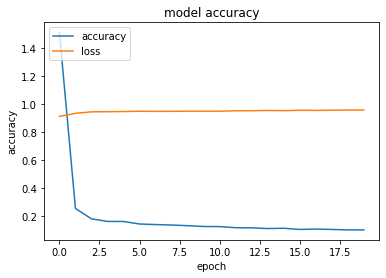

In [ ]:
history = save
plt.plot(history.history['loss'])
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'loss'], loc='upper left')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9526170798898072
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      5127
           1       0.92      0.21      0.34       318

    accuracy                           0.95      5445
   macro avg       0.93      0.60      0.66      5445
weighted avg       0.95      0.95      0.94      5445

[[5121    6]
 [ 252   66]]


### Decision Tree

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Define the parameter grid to search over
param_grid = {'max_depth': [3, 5, 7, 10],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4]}

# Create a Decision Tree classifier
dt = DecisionTreeClassifier(random_state=42)

# Create a grid search object to search over the parameter grid
grid_search = GridSearchCV(dt, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Use the best estimator to make predictions on the test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Compute the accuracy of the best estimator on the test data
accuracy_dt = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_dt)
print("Precision:", precision)
print("F1 score: ",f1)
cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(cm)

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2}
Accuracy: 0.9981634527089073
Precision: 0.98125
F1 score:  0.9843260188087775
Confusion matrix:
[[5121    6]
 [   4  314]]


### Naïve Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}

# Create a Gaussian Naive Bayes classifier
nb = GaussianNB()

# Create a grid search object to search over the parameter grid
grid_search = GridSearchCV(nb, param_grid, cv=5)

# Fit the grid search object to the training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Use the best estimator to make predictions on the test data
y_pred = grid_search.best_estimator_.predict(X_test)

# Compute the accuracy of the best estimator on the test data
accuracy_nb = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_nb)
print("Precision:", precision)
print("F1 score:", f1)

cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(cm)

Best parameters: {'var_smoothing': 1e-09}
Accuracy: 0.800734618916437
Precision: 0.22390208783297336
F1 score: 0.36438195664909195
Confusion matrix:
[[4049 1078]
 [   7  311]]


### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

param_grid = {'n_estimators': [50, 100, 150, 200]}
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
y_pred = grid_search.best_estimator_.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Best parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_rf)
print("Precision:", precision)
print("F1 score:", f1)

cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(cm)

Best parameters: {'n_estimators': 200}
Accuracy: 0.9990817263544536
Precision: 0.9936908517350158
F1 score: 0.9921259842519686
Confusion matrix:
[[5125    2]
 [   3  315]]


### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Resample the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Create a KNN classifier with k=2
knn = KNeighborsClassifier(n_neighbors=2)

# Fit the classifier to the training data
knn.fit(X_train_resampled, y_train_resampled)

# Use the classifier to make predictions on the test data
y_pred = knn.predict(X_test)

# Compute the accuracy, precision, and f1 score of the classifier on the test data
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the test accuracy, precision, and f1 score
print("Test accuracy:", accuracy)
print("Test precision:", precision)
print("Test f1 score:", f1)

cm = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion matrix:")
print(cm)

Test accuracy: 0.939761248852158
Test precision: 0.48842592592592593
Test f1 score: 0.5626666666666666
Confusion matrix:
[[4906  221]
 [ 107  211]]
